## Batch Evaluation
Set the folder parameter. Get an anaysis about all included batch evals

In [31]:
# import
import seaborn as sns
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import json
import os

#set path to folder
folder = "../../../eval-results/_server-results/test1"

['batch-birth-BINARY-2019-11-20 15:41:20.079', 'batch-birth-BINARY-2019-11-20 15:41:20.103', 'batch-birth-BINARY-2019-11-20 15:41:20.105', 'batch-birth-BINARY-2019-11-20 15:41:20.111', 'batch-birth-BINARY-2019-11-20 15:41:20.174', 'batch-birth-BINARY-2019-11-20-10:58:22.093', 'batch-birth-BINARY-2019-11-20 15:41:20.036', 'batch-birth-BINARY-2019-11-20-10:58:22.112', 'batch-birth-BINARY-2019-11-20-10:58:23.141', 'batch-birth-BINARY-2019-11-20 15:41:20.241', 'batch-birth-BINARY-2019-11-20-10:58:22.132', 'batch-birth-BINARY-2019-11-20-10:58:22.102', 'batch-birth-BINARY-2019-11-20 15:41:20.107', 'batch-birth-BINARY-2019-11-20 15:41:20.25', 'batch-birth-BINARY-2019-11-20 15:41:20.155', 'batch-birth-BINARY-2019-11-20-10:58:22.07', 'batch-birth-BINARY-2019-11-20-10:58:22.099', 'batch-birth-BINARY-2019-11-20 15:41:20.122', 'batch-birth-BINARY-2019-11-20 15:41:20.068', 'batch-birth-BINARY-2019-11-20 15:41:20.1', 'batch-birth-BINARY-2019-11-20 15:41:20.003']


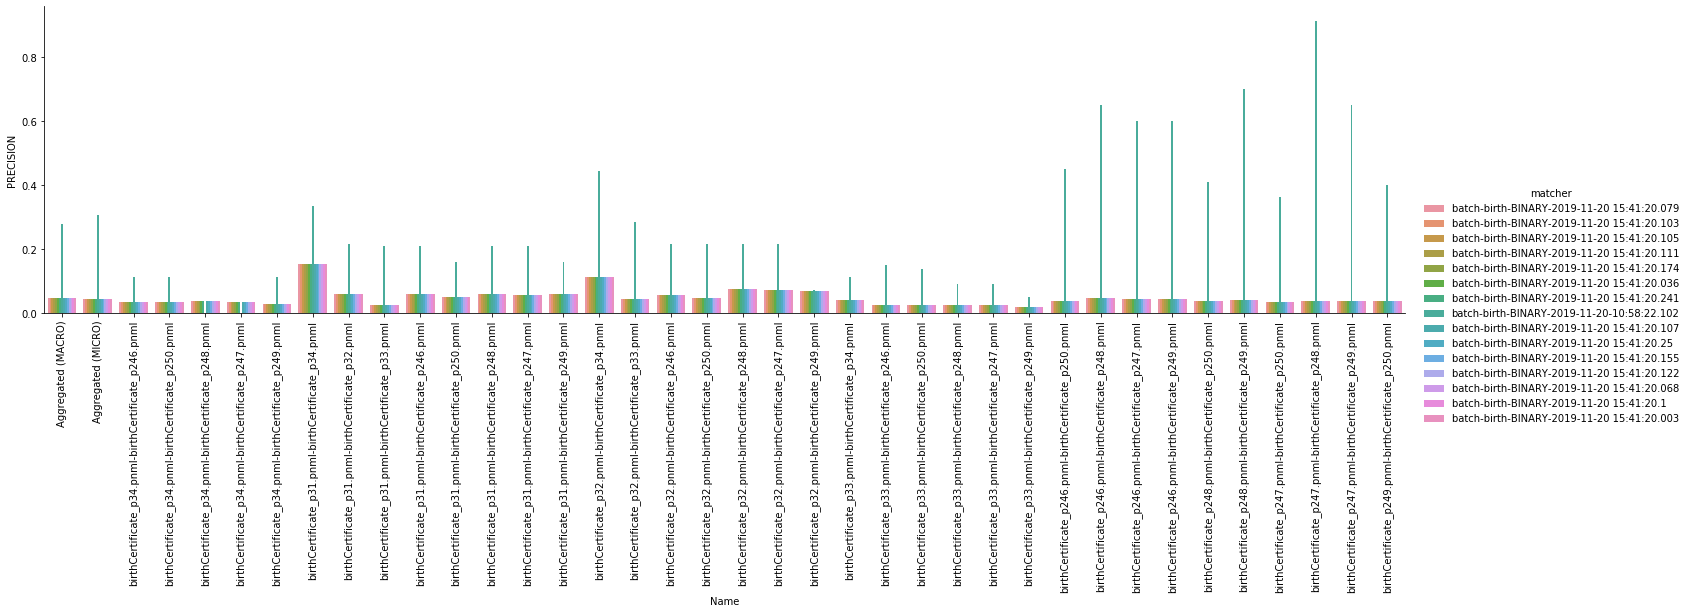

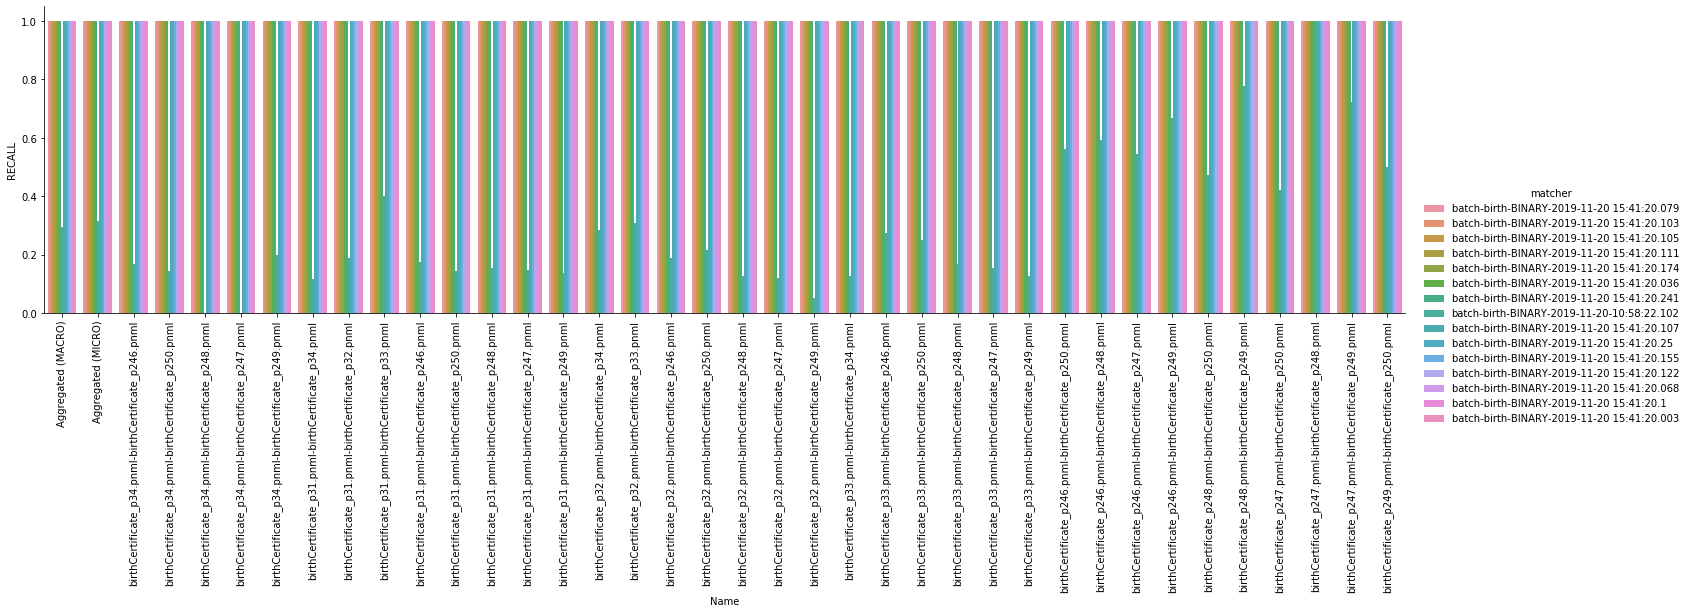

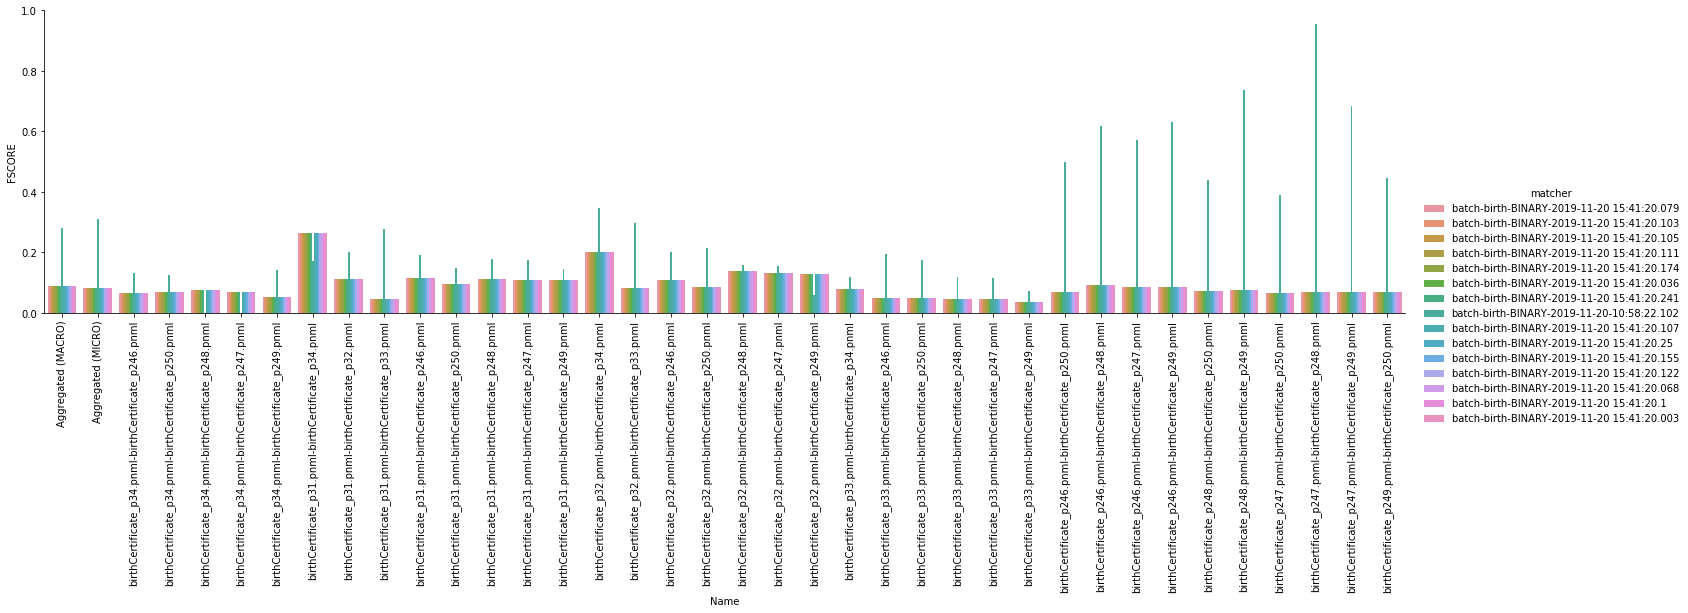

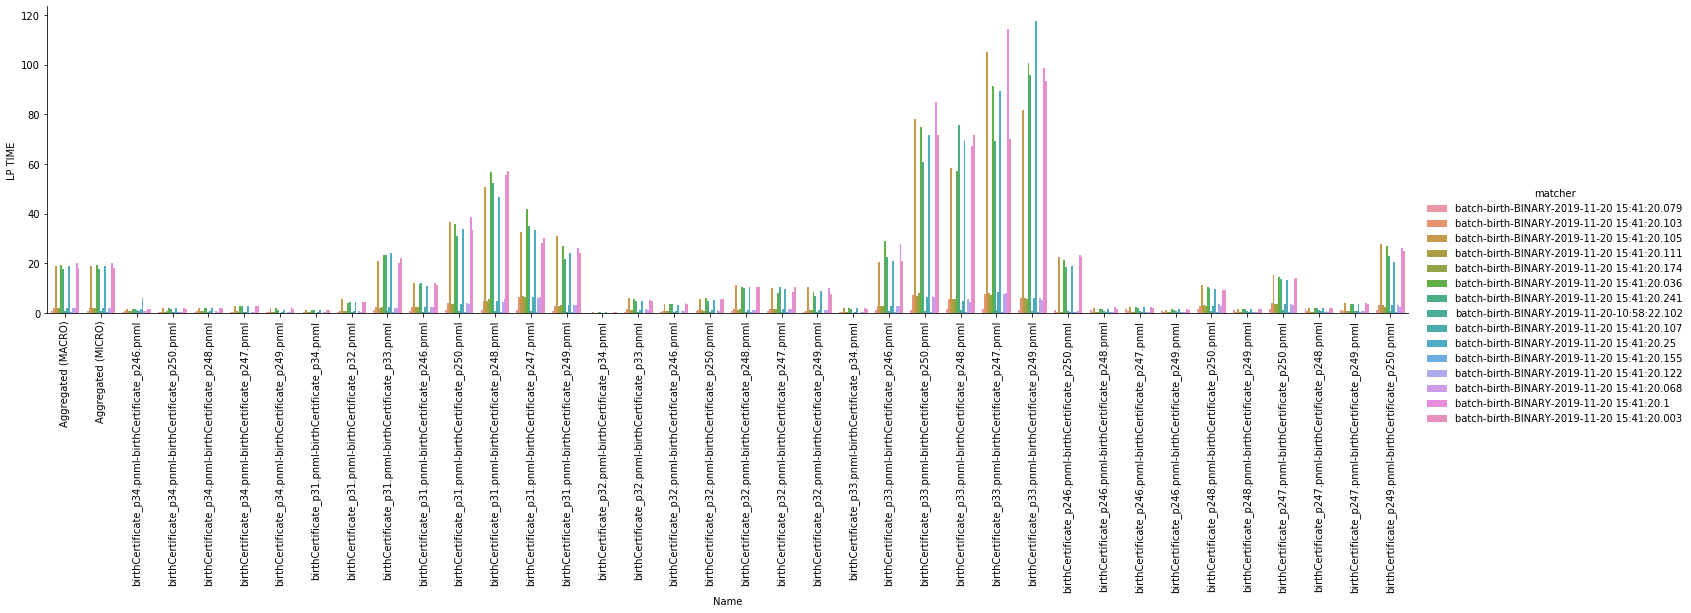

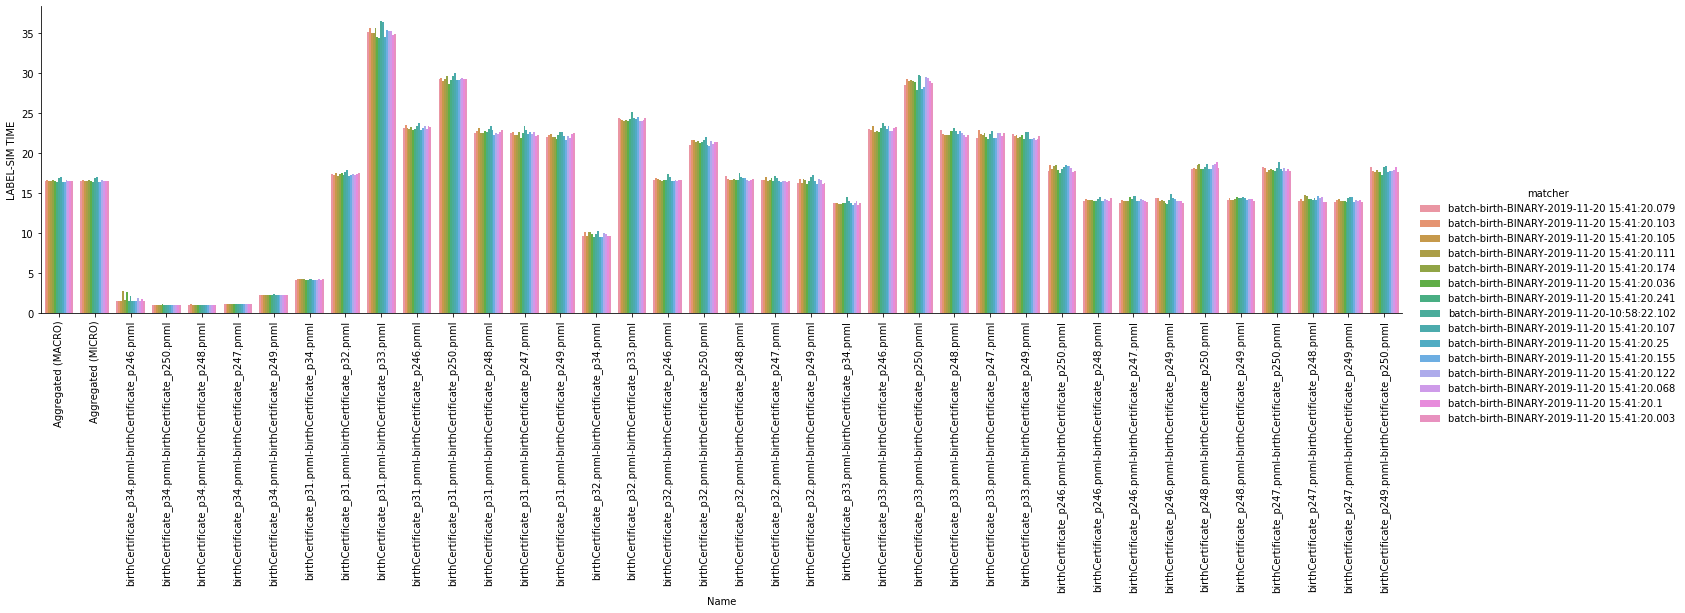

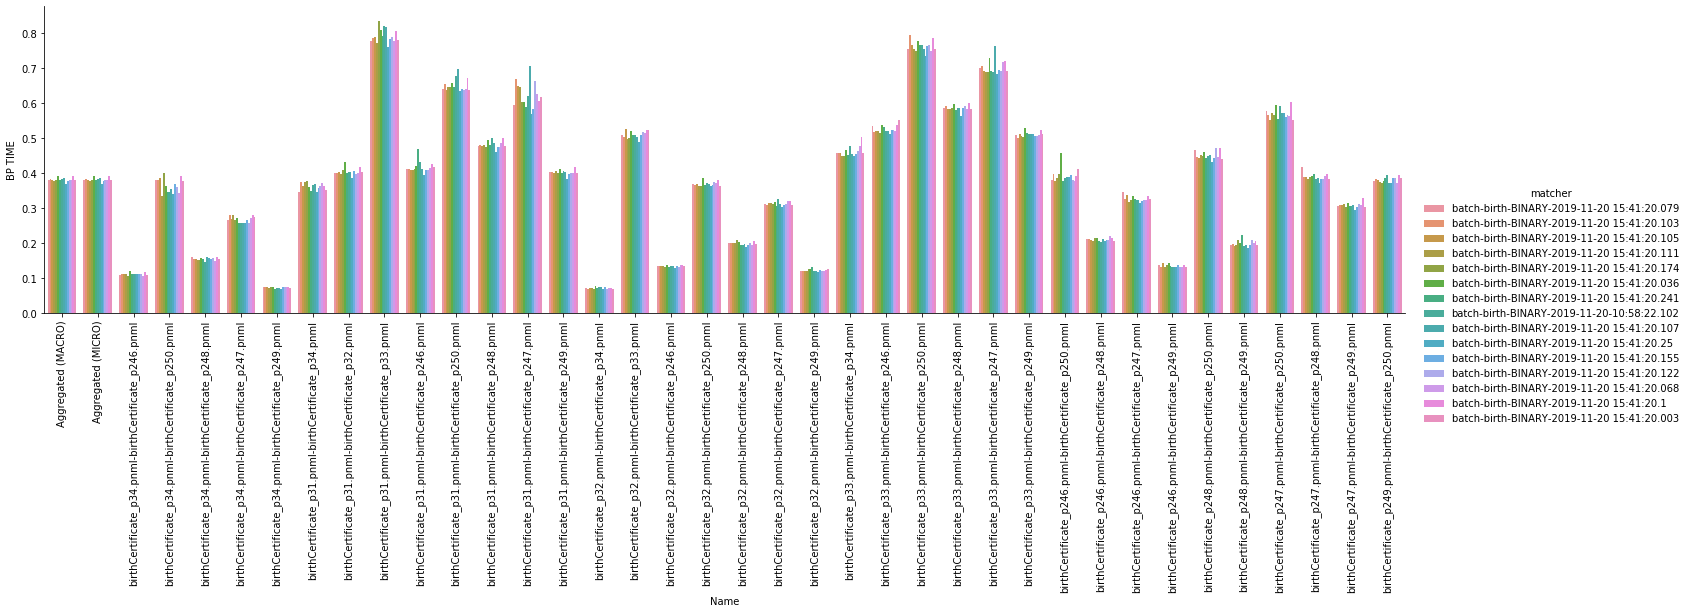

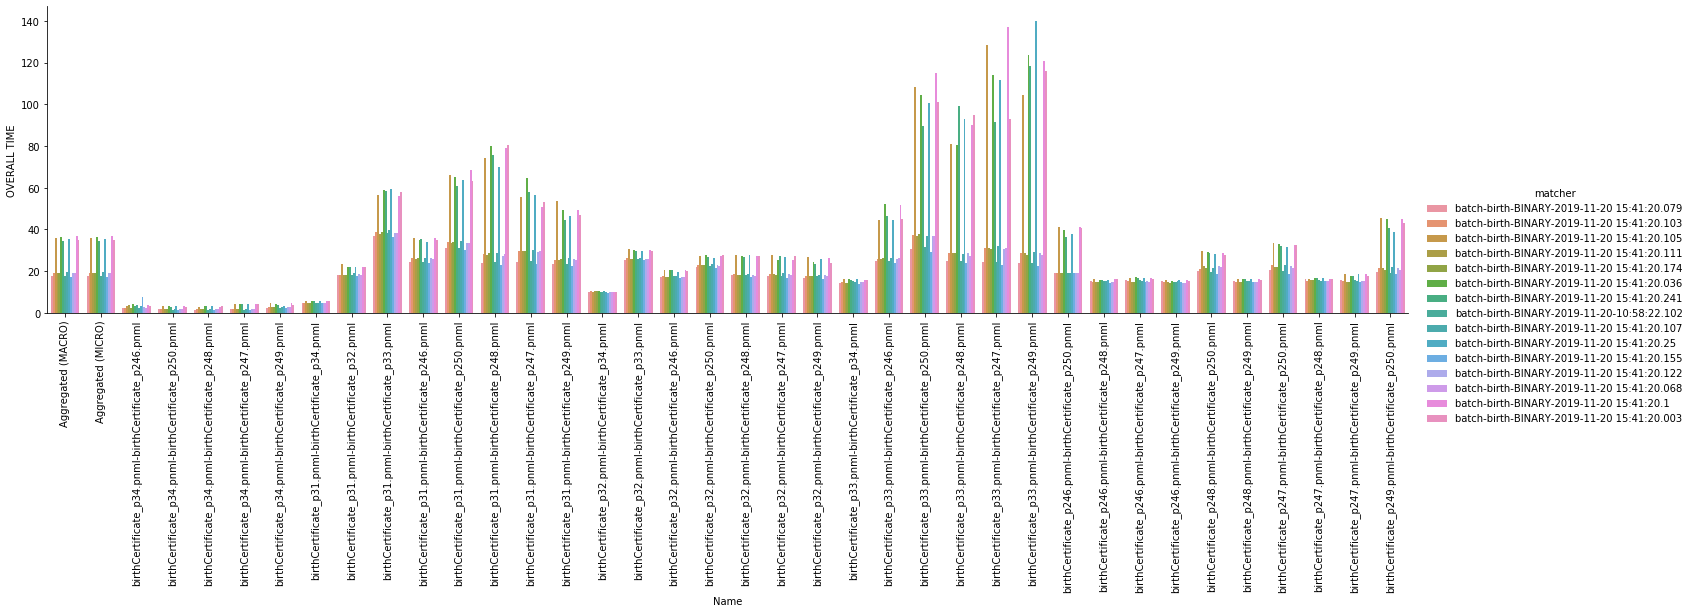

In [33]:
#get all subfolders
dir_list = next(os.walk(folder))[1]
dfs = []
print(dir_list)
#merge all 
for subfolder in dir_list:
    evalFile = folder +r"/" + subfolder +"/aggResults.eval"
    confFile = folder +r"/" + subfolder +"/config.log"
    if os.path.exists(evalFile):
        df = pd.read_csv(evalFile ,encoding="ISO-8859-1", skipinitialspace=True)
        
       # with open(confFile) as json_file:
           # conf = json.load(json_file)
            
        df['matcher'] = subfolder #conf['ilp']
        #df['complex-matches'] = conf['complex matches']
        df
        df.set_index(['Name','matcher'])
        dfs.append(df)
df_combined = pd.concat(dfs)

#convert time
df_combined['OVERALL TIME'] = df_combined['OVERALL TIME'].map(lambda x: x / 1000000000.)
df_combined['BP TIME'] = df_combined['BP TIME'].map(lambda x: x / 1000000000.)
df_combined['LABEL-SIM TIME'] = df_combined['LABEL-SIM TIME'].map(lambda x: x / 1000000000.)
df_combined['LP TIME'] = df_combined['LP TIME'].map(lambda x: x / 1000000000.)



# visualize Precision 
g = sns.catplot(x="Name", y="PRECISION", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize Recall
g = sns.catplot(x="Name", y="RECALL", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize FSCORE
g = sns.catplot(x="Name", y="FSCORE", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="LP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="LABEL-SIM TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="BP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="OVERALL TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)
